In [38]:
# data stuff and utilities:
from collections import deque
from tqdm.auto import tqdm
from tqdm import tqdm
import pandas as pd
import numpy as np
import logging
import csv
import re
import os

# gensim stuff:
import gensim
import gensim.downloader as api
from gensim.models import KeyedVectors
from gensim.models import Word2Vec, FastText
from gensim.models.phrases import Phrases, npmi_scorer

# plotting stuff:
import umap.umap_ as umap
from umap.umap_ import UMAP
import plotly.express as px
import matplotlib.pyplot as plt
from embeddings import plot_embeddings

# network graphs stuff:
from networkx.drawing.nx_pydot import graphviz_layout
import networkx as nx

---
<div class="alert alert-block alert-info">


### About this notebook:
In this notebook, we take a look at "Word Embedding" models to analyze text. See Page 270 of "Blueprints for Text Analytics Using Python".

Some resources: https://jalammar.github.io/illustrated-word2vec/

</div>

---
### Import data:

In [64]:
df = pd.read_csv('data/movie_descriptions.csv')
df.dropna(subset=['description'], inplace=True)
df.head(5)

id  movie_id     imdb_id                                        title  \
0   1    675353  12412888.0                         Sonic the Hedgehog 2   
1   2    453395   9419884.0  Doctor Strange in the Multiverse of Madness   
2   3    629542   8115900.0                                 The Bad Guys   
3   4    414906   1877830.0                                   The Batman   
4   5    335787   1464335.0                                    Uncharted   

                                         description                    genres  
0  After settling in Green Hills, Sonic is eager ...  [28, 878, 35, 10751, 12]  
1  Doctor Strange, with the help of mystical alli...              [14, 28, 12]  
2  When the infamous Bad Guys are finally caught ...   [16, 35, 28, 10751, 80]  
3  In his second year of fighting crime, Batman u...            [80, 9648, 53]  
4  A young street-smart, Nathan Drake and his wis...                  [28, 12]

---
### Import Gensim Model:

In [3]:
# load using api:
model = api.load("glove-wiki-gigaword-50")

&nbsp;

#### Similarity queries:

In [4]:
# define test vectors:
v_king = model['king']
v_queen = model['queen']

# inspect first five embeddings in the main vector for each (50 embeddings in total):
print("Vector size:", model.vector_size)
print("v_king  =", v_king[:5])
print("v_queen =", v_queen[:5])
print("similarity:", model.similarity('king', 'queen'))

Vector size: 50
v_king  = [ 0.50451   0.68607  -0.59517  -0.022801  0.60046 ]
v_queen = [ 0.37854  1.8233  -1.2648  -0.1043   0.35829]
similarity: 0.7839043


In [5]:
# find the three most similar words to 'king':
model.most_similar('king', topn=3)

[('prince', 0.8236179351806641),
 ('queen', 0.7839043140411377),
 ('ii', 0.7746230363845825)]

In [6]:
# find similarity between king and other sample vectors:
v_lion = model['lion']
v_nano = model['nanotechnology']

model.cosine_similarities(v_king, [v_queen, v_lion, v_nano])

array([ 0.7839043 ,  0.47800118, -0.25490996], dtype=float32)

&nbsp;

#### Use positive and negative vectors to return most similar results:

In [7]:
model.most_similar(positive=['woman', 'king'], negative=['man'], topn=3)

[('queen', 0.8523604273796082),
 ('throne', 0.7664334177970886),
 ('prince', 0.7592144012451172)]

In [8]:
model.most_similar(positive=['paris', 'germany'], negative=['france'], topn=3)

[('berlin', 0.9203965663909912),
 ('frankfurt', 0.8201637268066406),
 ('vienna', 0.8182448744773865)]

In [9]:
model.most_similar(positive=['france', 'capital'], topn=1)

[('paris', 0.7835100293159485)]

<div class="alert alert-block alert-warning">

**Note:** as described in the original word2vec papers, it performs vector arithmetic: adding the positive vectors, subtracting the negative, then from that resulting position, listing the known-vectors closest to that angle.

You can think of this as, "start at 'king'-vector, add 'woman'-vector, subtract 'man'-vector, from where you wind up, report ranked word-vectors closest to that point (while leaving out any of the 3 query vectors).
</div>

---
---
<div class="alert alert-block alert-info">


### Training Models with Gensim - Movie Description as corpus:

</div>

#### First, tokenize the descriptions into sentences, then into individual tokens:

In [66]:
from nltk import tokenize

# join all descriptions into a single block of text:
text = ' '.join(df['description'])

# tokenize into sentences:
full_sentences = tokenize.sent_tokenize(text.lower())

# turn it into individual tokens:
sentences = [re.sub("[.,']", '', x).split() for x in full_sentences]

#### Define Word2Vec model:

In [68]:
model = Word2Vec(sentences,          # tokenized input sentences
                 vector_size=100,    # size of word vectors (default 100) 
                 window=2,           # context window size (default 5)
                 sg=1,               # use skip-gram (default 0 = CBOW)
                 negative=5,         # number of negative samples (default 5)
                 min_count=5,        # ignore infrequent words (default 5)
                 workers=4,          # number of threads (default 3)
                 epochs=5)           # number of epochs (default 5)

In [69]:
# save into models dir:
model.save('./models/movies_w2v_100_2_full.bin')

In [70]:
# load from file:
model = Word2Vec.load('./models/movies_w2v_100_2_full.bin')

&nbsp;

#### Create a parameter grid that will create several models for comparison:

In [71]:
# set path to save all "keyed vectors" (see page 283) and their prefix:
model_path = './models'
model_prefix = 'movies'

# iterate over models (Word2Vec: CBOW, Skip-Gram) and (FastText: Skip-Gram),
# also, iterate over various "context" window sizes (i.e. -30...target...+30):
param_grid = {'w2v': {'variant': ['cbow', 'sg'], 'window': [2, 5, 30]},
              'ft': {'variant': ['sg'], 'window': [5]}}

# set the size for "embedded" vectors:
size = 100

# iterate:
for algo, params in param_grid.items(): 
    print(algo)
    for variant in params['variant']:
        sg = 1 if variant == 'sg' else 0
        for window in params['window']:
            print(f"  Variant: {variant}, Window: {window}, Size: {size}")
            np.random.seed(1) ### to ensure repeatability
            if algo == 'w2v':
                model = Word2Vec(sentences, vector_size=size, window=window, sg=sg)
            else:
                model = FastText(sentences, vector_size=size, window=window, sg=sg)
            
            # save vector:
            file_name = f"{model_path}/{model_prefix}_{algo}_{variant}_{window}"
            model.wv.save_word2vec_format(file_name + '.bin', binary=True)


w2v
  Variant: cbow, Window: 2, Size: 100
  Variant: cbow, Window: 5, Size: 100
  Variant: cbow, Window: 30, Size: 100
  Variant: sg, Window: 2, Size: 100
  Variant: sg, Window: 5, Size: 100
  Variant: sg, Window: 30, Size: 100
ft
  Variant: sg, Window: 5, Size: 100


In [72]:

model_path = './models' ###

names = ['movies_w2v_cbow_2', 'movies_w2v_sg_2', 
         'movies_w2v_sg_5', 'movies_w2v_sg_30', 'movies_ft_sg_5']
models = {}

for name in names:
    file_name = f"{model_path}/{name}.bin"
    print(f"Loading {file_name}") ###
    models[name] = KeyedVectors.load_word2vec_format(file_name, binary=True)

Loading ./models/movies_w2v_cbow_2.bin
Loading ./models/movies_w2v_sg_2.bin
Loading ./models/movies_w2v_sg_5.bin
Loading ./models/movies_w2v_sg_30.bin
Loading ./models/movies_ft_sg_5.bin


&nbsp;

#### Compare Models:

In [73]:
# define funtion to load and evaluate a target word for each trained model:
def compare_models(models, **kwargs):
    # df to hold results
    df = pd.DataFrame()
    
    # iterate and evaluate:
    for name, model in models:
        df[name] = [f"{word} {score:.3f}" 
                    for word, score in model.most_similar(**kwargs)]
    df.index = df.index + 1 # let row index start at 1
    return df

In [97]:
# get the top ten closest words to "police" by similarity to each model:
compare_models([(n, models[n]) for n in names], positive='police', topn=10)

movies_w2v_cbow_2  movies_w2v_sg_2  movies_w2v_sg_5  movies_w2v_sg_30  \
1         drug 0.978    chinese 0.849  detective 0.869         cop 0.851   
2         star 0.970       hong 0.845    officer 0.849    homicide 0.844   
3      british 0.965       kong 0.844    corrupt 0.835       chief 0.833   
4     ruthless 0.961    officer 0.843   assigned 0.832         fbi 0.828   
5       german 0.961  detective 0.841      chief 0.826    district 0.826   
6   university 0.960        fbi 0.840        fbi 0.822      framed 0.825   
7        local 0.959    soldier 0.825        cop 0.821  department 0.820   
8     criminal 0.959    russian 0.823  inspector 0.816     officer 0.818   
9      popular 0.958    federal 0.822      local 0.814       mafia 0.818   
10       black 0.958       lapd 0.822       kong 0.810        lapd 0.816   

      movies_ft_sg_5  
1       policy 0.961  
2    policeman 0.950  
3    policemen 0.941  
4       office 0.919  
5    detective 0.918  
6      officer 0.914  
7          fbi 0.910  
8   detectives 0.908  
9          cia 0.906  
10       chief 0.903

In [109]:
# "what is to soldier as detective is to police"?
compare_models([(n, models[n]) for n in names], 
               positive=['detective', 'soldier'], negative=['police'], topn=5).T

1                  2                   3  \
movies_w2v_cbow_2     smuggle 0.965     hak-sung 0.964         stark 0.964   
movies_w2v_sg_2    journalist 0.883  businessman 0.877  psychologist 0.865   
movies_w2v_sg_5    journalist 0.875      veteran 0.854       retired 0.850   
movies_w2v_sg_30      wounded 0.755  apocalyptic 0.749      imminent 0.741   
movies_ft_sg_5     ex-soldier 0.913         solo 0.884       veteran 0.873   

                                        4             5  
movies_w2v_cbow_2              buys 0.964  ex-cop 0.964  
movies_w2v_sg_2              driver 0.863  rookie 0.860  
movies_w2v_sg_5              hunter 0.849  dealer 0.844  
movies_w2v_sg_30   post-apocalyptic 0.729    iraq 0.723  
movies_ft_sg_5              russian 0.870  korean 0.868

In [76]:
# and now compare the results for "alien":
compare_models([(n, models[n]) for n in names], 
               positive=['alien'], negative=[], topn=5)

movies_w2v_cbow_2      movies_w2v_sg_2     movies_w2v_sg_5  \
1    alliance 0.984        unknown 0.909       ancient 0.880   
2       novel 0.982         attack 0.894      invasion 0.866   
3       state 0.982  action-packed 0.887  organization 0.863   
4     endless 0.982       backdrop 0.874        attack 0.856   
5     captain 0.981        illegal 0.871   underground 0.856   

    movies_w2v_sg_30   movies_ft_sg_5  
1      mutated 0.865     aliens 0.956  
2     epidemic 0.848     invade 0.907  
3       colony 0.844  unleashed 0.893  
4  crash-lands 0.833     zombie 0.887  
5      hostile 0.832    ancient 0.884

&nbsp;

---
---
<div class="alert alert-block alert-info">


### Embeddings visualization:

</div>

In [78]:
# load a candidate model to visualize:
model = models['movies_w2v_sg_30']
words = model.index_to_key
wv = [model[word] for word in words]

# reduce dimensions down to two dimensions:
reducer = UMAP(n_components=2, metric='cosine', n_neighbors = 15, min_dist=0.1, random_state = 12)
reduced_wv = reducer.fit_transform(wv)

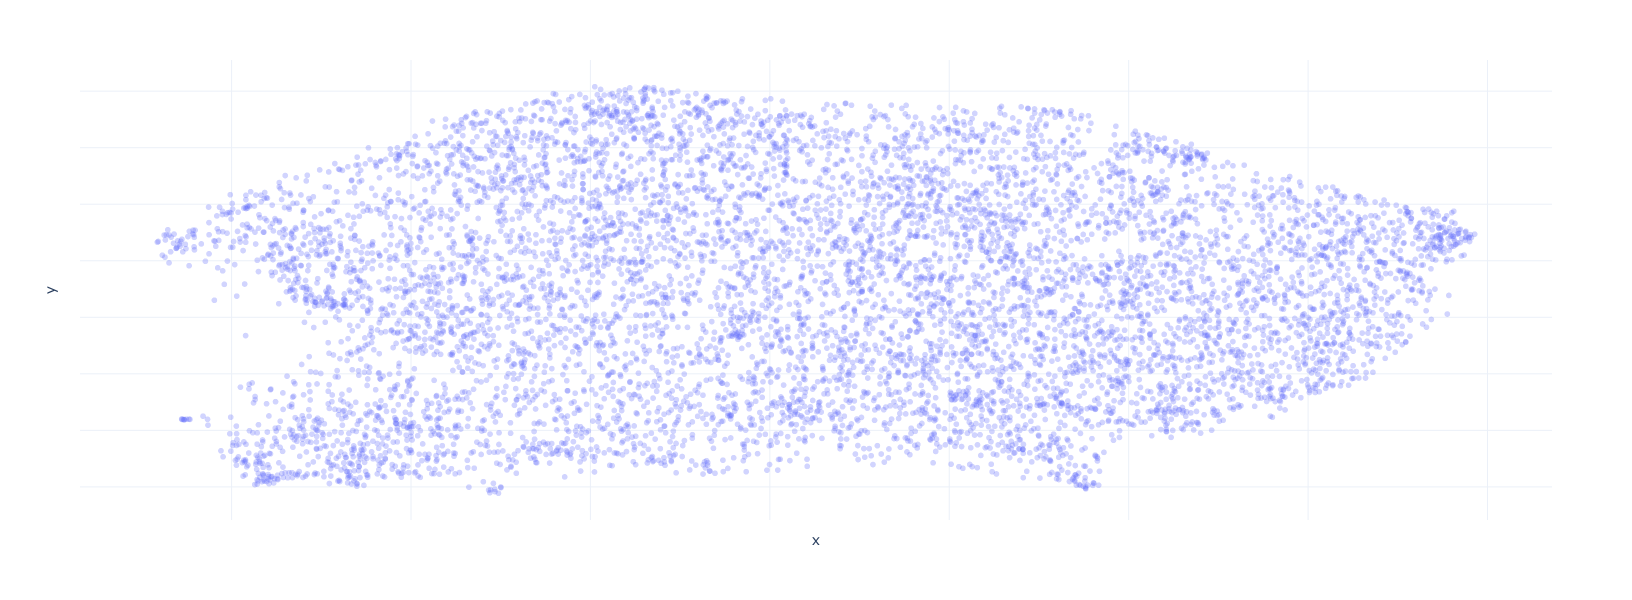

In [110]:
# plot - returns ALL WORDS and their neighbors:
px.defaults.template = "plotly_white"
plot_df = pd.DataFrame.from_records(reduced_wv, columns=['x', 'y'])
plot_df['word'] = words
params = {'hover_data': {c: False for c in plot_df.columns}, 
          'hover_name': 'word'}
params.update({'width': 800, 'height': 600}) ###

fig = px.scatter(plot_df, x="x", y="y", opacity=0.3, size_max=3, **params)
fig.update_traces(marker={'line': {'width': 0}}) ###
fig.update_xaxes(showticklabels=False, showgrid=True, zeroline=False, visible=True) ###
fig.update_yaxes(showticklabels=False, showgrid=True, zeroline=False, visible=True) ###
fig.show()

Calculating umap for 8244 words ... done.


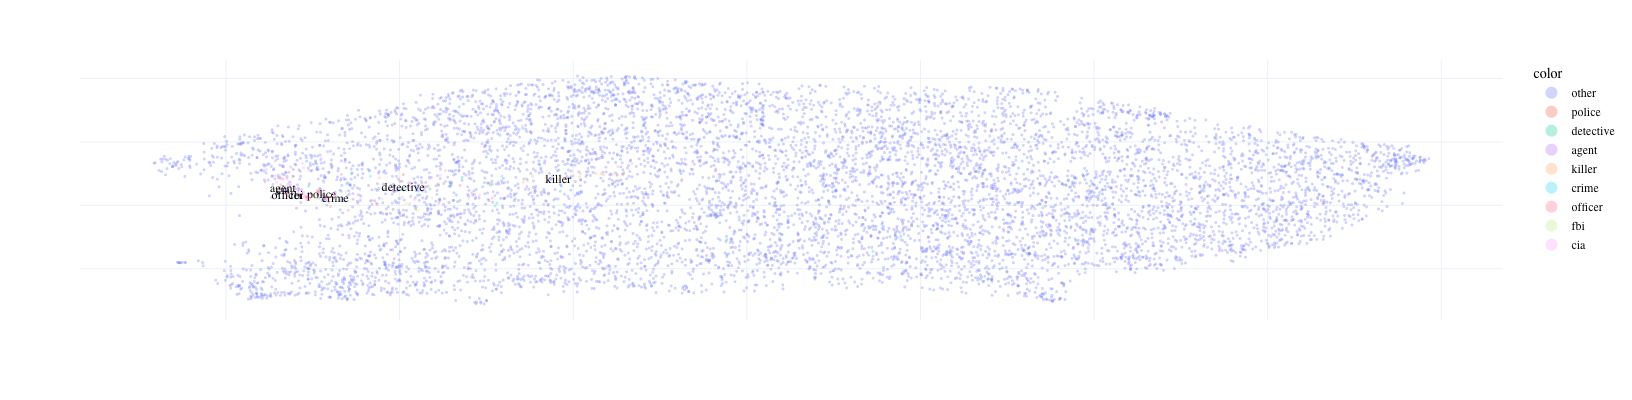

In [111]:
# highlight serch terms in the embedding cloud:
model = models['movies_w2v_sg_30']
search = ['police', 'detective', 'killer', 'agent', 
          'crime', 'fbi', 'officer', 'cia']

# search = ['love', 'boy', 'girl', 'story', 
#           'romance', 'man', 'woman', 'passion']

_ = plot_embeddings(model, search, topn=50, show_all=True, labels=False, 
                algo='umap', n_neighbors=15, min_dist=0.1, random_state=12)

Calculating umap for 141 words ...

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/umap_.py:1356: RuntimeWarning:

divide by zero encountered in power



 done.


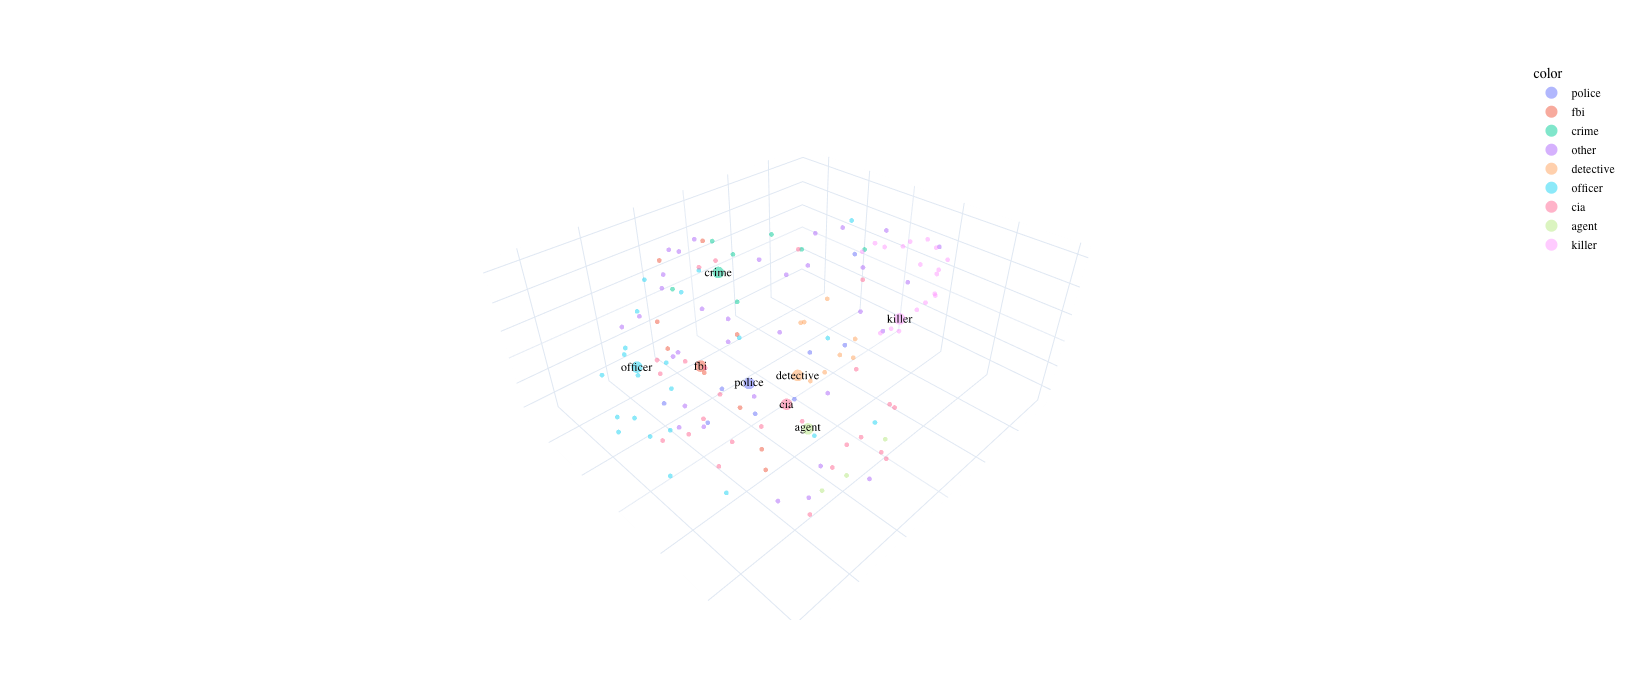

In [81]:
# return three-dimensional plot:
_ = plot_embeddings(model, search, topn=30, n_dims=3, 
    algo='umap', n_neighbors=15, min_dist=.1, spread=40, random_state=23)

Calculating pca for 8 words ... done.


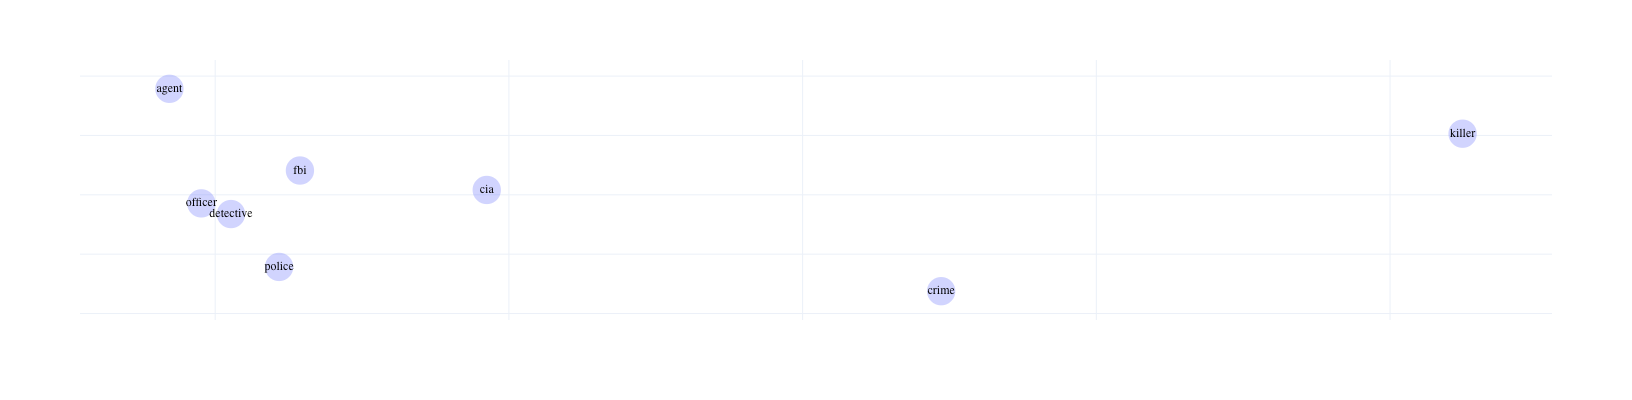

In [82]:
# return only candidate words and their close neighborhood:
model = models['movies_w2v_sg_5'] 
search = ['police', 'detective', 'killer', 'agent', 
          'crime', 'fbi', 'officer', 'cia']
_ = plot_embeddings(model, search, topn=0, algo='pca', labels=True, colors=False)

&nbsp;

---
---
<div class="alert alert-block alert-info">


### Construct a similarity tree :

</div>

#### Define graph functions below unsing NetworkX:

In [84]:
def sim_tree(model, word, top_n, max_dist):

    graph = nx.Graph()
    graph.add_node(word, dist=0)

    to_visit = deque([word])
    while len(to_visit) > 0:
        source = to_visit.popleft() # visit next node
        dist = graph.nodes[source]['dist']+1

        if dist <= max_dist: # discover new nodes
            for target, sim in model.most_similar(source, topn=top_n):
                if target not in graph:
                    to_visit.append(target)
                    graph.add_node(target, dist=dist)
                    graph.add_edge(source, target, sim=sim, dist=dist)
    return graph

In [85]:
def plt_add_margin(pos, x_factor=0.1, y_factor=0.1):
    # rescales the image s.t. all captions fit onto the canvas
    x_values, y_values = zip(*pos.values())
    x_max = max(x_values)
    x_min = min(x_values)
    y_max = max(y_values)
    y_min = min(y_values)

    x_margin = (x_max - x_min) * x_factor
    y_margin = (y_max - y_min) * y_factor
    # return (x_min - x_margin, x_max + x_margin), (y_min - y_margin, y_max + y_margin)

    plt.xlim(x_min - x_margin, x_max + x_margin)
    plt.ylim(y_min - y_margin, y_max + y_margin)

def scale_weights(graph, minw=1, maxw=8):
    # rescale similarity to interval [minw, maxw] for display
    sims = [graph[s][t]['sim'] for (s, t) in graph.edges]
    min_sim, max_sim = min(sims), max(sims)

    for source, target in graph.edges:
        sim = graph[source][target]['sim']
        graph[source][target]['sim'] = (sim-min_sim)/(max_sim-min_sim)*(maxw-minw)+minw

    return graph

def solve_graphviz_problems(graph):
    # Graphviz has problems with unicode
    # this is to prevent errors during positioning
    def clean(n):
        n = n.replace(',', '')
        n = n.encode().decode('ascii', errors='ignore')
        n = re.sub(r'[{}\[\]]', '-', n)
        n = re.sub(r'^\-', '', n)
        return n
    
    node_map = {n: clean(n) for n in graph.nodes}
    # remove empty nodes
    for n, m in node_map.items(): 
        if len(m) == 0:
            graph.remove_node(n)
    
    return nx.relabel_nodes(graph, node_map)

In [88]:
def plot_tree(graph, node_size=1000, font_size=12):
    graph = solve_graphviz_problems(graph) ###

    pos = graphviz_layout(graph, prog='twopi', root=list(graph.nodes)[0])
    plt.figure(figsize=(10, 4), dpi=200) ###
    plt.grid(visible=None) ### hide box
    plt.box(False) ### hide grid
    plt_add_margin(pos) ### just for layout

    colors = [graph.nodes[n]['dist'] for n in graph] # colorize by distance
    nx.draw_networkx_nodes(graph, pos, node_size=node_size, node_color=colors, 
                           cmap='Set1', alpha=0.4)
    nx.draw_networkx_labels(graph, pos, font_size=font_size)
    scale_weights(graph) ### not in book
    
    for (n1, n2, sim) in graph.edges(data='sim'):
         nx.draw_networkx_edges(graph, pos, [(n1, n2)], width=sim, alpha=0.2)

    plt.show()

#### Load model, define target word, and plot:

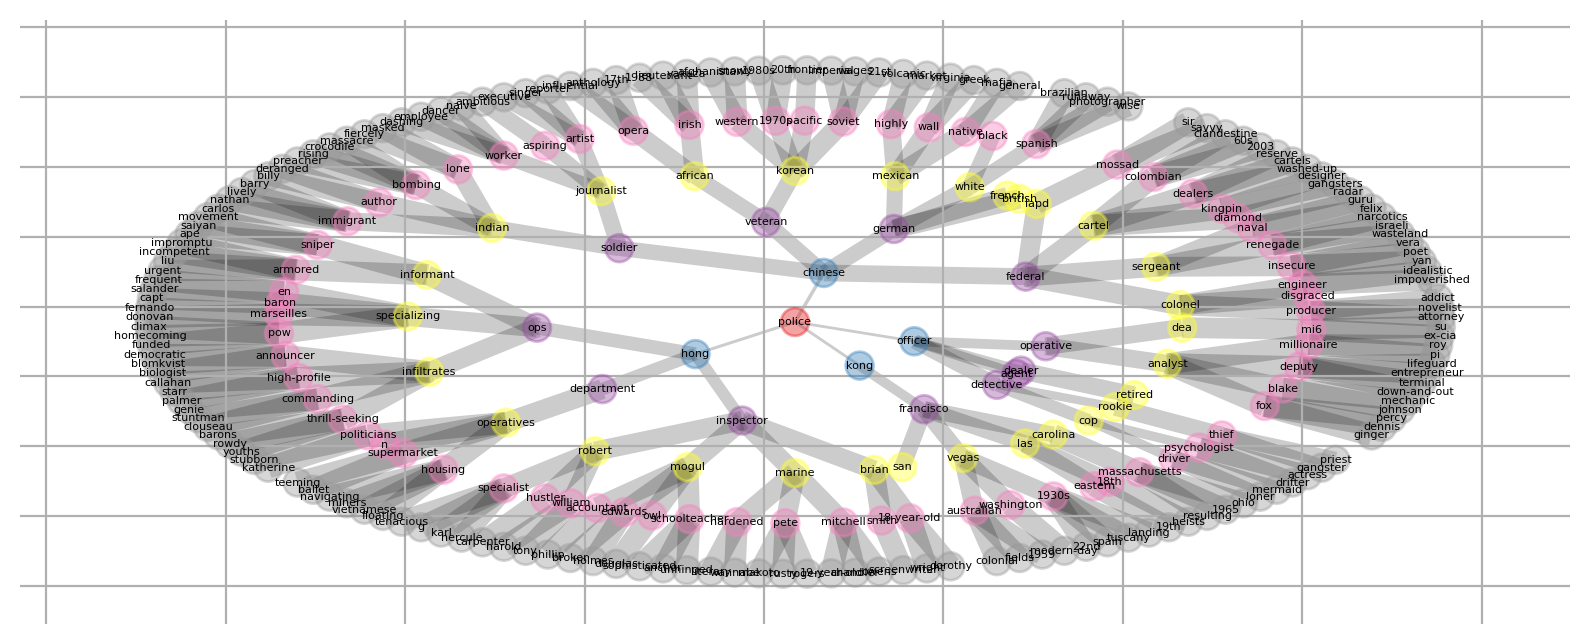

In [96]:
model = models['movies_w2v_sg_2']
graph = sim_tree(model, 'police', top_n=4, max_dist=5)
plot_tree(graph, node_size=100, font_size=4)